In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd

import pickle
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

import matplotlib
from astromcad.astromcad import *

2024-07-01 17:01:18.710841: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 17:01:20.590997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 17:01:20.592542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 17:01:20.784125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 17:01:21.147261: I tensorflow/core/platform/cpu_feature_guar

In [2]:
file_names_load = ['lc_classnum_Ia-norm_90.pickle',
 'lc_classnum_Ia-91bg_67.pickle',
 'lc_classnum_Iax_52.pickle',
'lc_classnum_Ib.pickle',
 'lc_classnum_Ic.pickle',
 'lc_classnum_Ic-BL.pickle',
 'lc_classnum_II.pickle',
 'lc_classnum_IIn.pickle',
 'lc_classnum_IIb.pickle',
 'lc_classnum_TDE_64.pickle',
 'lc_classnum_SLSN-I_60.pickle',
 'lc_classnum_AGN_70_old.pickle',
 'lc_classnum_CART_63_old.pickle',
 'lc_classnum_Kilonova_99.pickle',
'lc_classnum_PISN_61_old.pickle',
'lc_classnum_ILOT_62_old.pickle',
'lc_classnum_uLens-BSR_90_old.pickle']

file_names = ['lc_classnum_Ia.pickle',
 'lc_classnum_Ia-91bg.pickle',
 'lc_classnum_Iax.pickle',
'lc_classnum_Ib.pickle',
 'lc_classnum_Ic.pickle',
 'lc_classnum_Ic-BL.pickle',
 'lc_classnum_II.pickle',
 'lc_classnum_IIn.pickle',
 'lc_classnum_IIb.pickle',
 'lc_classnum_TDE.pickle',
 'lc_classnum_SLSN-I.pickle',
 'lc_classnum_AGN_old.pickle',
 'lc_classnum_CART_old.pickle',
 'lc_classnum_Kilonova.pickle',
'lc_classnum_PISN_old.pickle',
'lc_classnum_ILOT_old.pickle',
'lc_classnum_uLens-BSR.pickle']

classes = ['SNIa', 'SNIa-91bg', 'SNIax', 'SNIb', 'SNIc', 'SNIc-BL', 'SNII', 'SNIIn', 'SNIIb', 'TDE', 'SLSN-I', 'AGN', 'CaRT', 'KNe', 'PISN', 'ILOT', 'uLens-BSR']

file_to_class = dict(zip(file_names, classes))


class_to_file = {v: k for k, v in file_to_class.items()}
class_to_file['SNIa-x'] = class_to_file['SNIax']
class_to_file['SNIa-norm'] = class_to_file['SNIa']

anom_classes = file_names[-5:]
non_anom_classes = file_names[:-5]


color = ['r', 'g', 'y', 'b', 'purple', 'orange', 'gray', 'k', 'm', 'c', 'brown', 'olive']
colors = color

font = {'size'   : 17}

matplotlib.rc('font', **font)
anom_classes = [file_to_class[i] for i in anom_classes]
non_anom_classes = [file_to_class[i] for i in non_anom_classes]


In [3]:
def save(save_path , obj):
    with open(save_path, 'wb') as f:
        pickle.dump(obj, f)

def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

target = load("data/target")
x_data = load("data/x_data")
host_galaxy_info = load("data/host_galaxy_info")


In [4]:
valid = [False] * len(target)

for class_ in np.unique(target):
    cnt = 0
    for i in range(len(target)):

        if (target[i] == class_):
            valid[i] = True
            cnt+=1
        if (cnt == 13000): # cut down
            break
for i in range(len(target) - 1, -1, -1):
    if not valid[i]:
        del target[i]
        del x_data[i]
        del host_galaxy_info[i]

lengths = []

for lc in x_data:
    lengths.append(len(lc))

ntimesteps = np.max(lengths)

print(ntimesteps)

# Pad for TF masking layer and time dilation
def dilate(vals, red):
    return ((((vals * 100) - 30) / (1 + red)) + 30) / 100 # unscale time then correct


for ind in range(len(x_data)):
  x_data[ind][:, 1] = dilate(x_data[ind][:, 1], host_galaxy_info[ind][0])
  x_data[ind] = np.pad(x_data[ind], ((0, ntimesteps - len(x_data[ind])), (0, 0)))
# x_data = np.array(x_data)
# Split data

y_data_anom = []
y_data_norm = []
x_data_norm = []
x_data_anom = []
host_gal_anom = []
host_gal = []

for i in range(len(target)):

    if (file_to_class[target[i]] in anom_classes):
        x_data_anom.append(x_data[i])
        y_data_anom.append(target[i])
        host_gal_anom.append(host_galaxy_info[i])

    else:
        x_data_norm.append(x_data[i])
        y_data_norm.append(target[i])
        host_gal.append(host_galaxy_info[i])

656


In [5]:

# One-hot Encoding
print(np.unique(y_data_norm))
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_data_norm = enc.fit_transform(np.array(y_data_norm).reshape(-1, 1)).todense()
# Train-test split

X_train, X_test, host_gal_train, host_gal_test, y_train, y_test = train_test_split(x_data_norm, host_gal, y_data_norm, random_state = 40, test_size = 0.1)
X_train, X_val, host_gal_train, host_gal_val, y_train, y_val = train_test_split(X_train, host_gal_train, y_train, random_state = 40, test_size = 1/9)
class_weights = {i : 0 for i in range(y_train.shape[1])}

for value in y_train:
  class_weights[np.argmax(value)]+=1

for id in class_weights.keys():
  class_weights[id] = len(y_train) / class_weights[id]

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

host_gal_train = np.array(host_gal_train)
host_gal_test = np.array(host_gal_test)
host_gal_val = np.array(host_gal_val)

y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)
y_test = np.squeeze(y_test)
y_data_anom = np.squeeze(y_data_anom)
X_train.shape

['lc_classnum_AGN_old.pickle' 'lc_classnum_II.pickle'
 'lc_classnum_IIb.pickle' 'lc_classnum_IIn.pickle'
 'lc_classnum_Ia-91bg.pickle' 'lc_classnum_Ia.pickle'
 'lc_classnum_Iax.pickle' 'lc_classnum_Ib.pickle'
 'lc_classnum_Ic-BL.pickle' 'lc_classnum_Ic.pickle'
 'lc_classnum_SLSN-I.pickle' 'lc_classnum_TDE.pickle']


(95182, 656, 4)

In [6]:
dummy = enc.transform(np.array([class_to_file[i] for i in non_anom_classes]).reshape(-1, 1))

ordered_class_names = [-1 for i in range(len(non_anom_classes))]

for ind, i in enumerate(dummy.todense()):
    ordered_class_names[np.argmax(i)] = non_anom_classes[ind]

In [7]:
ordered_class_names

['AGN',
 'SNII',
 'SNIIb',
 'SNIIn',
 'SNIa-91bg',
 'SNIa',
 'SNIax',
 'SNIb',
 'SNIc-BL',
 'SNIc',
 'SLSN-I',
 'TDE']

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Masking, concatenate, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from math import dist
import keras
def make_classifier_model(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

    input_2 = Input(shape = (2, ), name='host') # CHANGE

    dense2 = Dense(10)(input_2)

    merge1 = concatenate([dense1, dense2])

    dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense3)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1, input_2], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

def make_classifier_no_host(latent_size):

    num_classes = len(class_weights)
    n_features = 4

    input_1 = Input((ntimesteps, n_features), name='lc')  # X.shape = (Nobjects, Ntimesteps, 4) CHANGE

    masking_input1 = Masking(mask_value=0.)(input_1)

    lstm1 = GRU(100, return_sequences=True, activation='tanh')(masking_input1)
    lstm2 = GRU(100, return_sequences=False, activation='tanh')(lstm1)

    dense1 = Dense(100, activation='tanh')(lstm2)

#     input_2 = Input(shape = (2, ), name='host') # CHANGE

#     dense2 = Dense(10)(input_2)

#     merge1 = concatenate([dense1, dense2])

#     dense3 = Dense(100, activation='relu')(merge1)

    dense4 = Dense(latent_size, activation='relu', name='latent')(dense1)

    output = Dense(num_classes, activation='softmax')(dense4)

    model = keras.Model(inputs=[input_1], outputs=output)

    model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    return model

In [9]:
# Measure feature correlation of the latent space

def train_model(latent_size, host=True):
    if (host):
        model = make_classifier_model(latent_size) # HERE YOU CAN CHANGE THE LATENT SPACE SIZE
    else:
        model = make_classifier_no_host(latent_size) # HERE YOU CAN CHANGE THE LATENT SPACE SIZE
        
    early_stopping = EarlyStopping(
                                  patience=5,
                                  min_delta=0.001,                               
                                  monitor="val_loss",
                                  restore_best_weights=True
                                  )



    try:
        if (host):
            history = model.fit(x = [X_train, host_gal_train], validation_data=([X_val, host_gal_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
        else:
            history = model.fit(x = [X_train], validation_data=([X_val], y_val), y = y_train, epochs=40, batch_size = 128, class_weight = class_weights, callbacks=[early_stopping])
            
    except Exception as e:
        print(e)
        pass
    
    
    return model


In [10]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, auc
single_test = [np.argmax(i) for i in y_test]

def get_auroc(predictions, single_test):
    rocs = []
    for i in range(len(non_anom_classes)):
      fpr, tpr, _ = roc_curve(y_true = single_test, y_score = predictions[:, i], pos_label = i)
      rocs.append(round(auc(fpr, tpr), 2))
    
    return np.array(rocs)
    

In [14]:
szs = [9, 20, 30, 40, 60, 70, 80, 90, 100, 125, 150, 175]

all = list(range(10, 260, 10))
rec = []
done = []
cls_perf = []

In [38]:
cls_perf = [model.evaluate([X_test, host_gal_test],y_test)]

372/372 [==============================] - 2s 6ms/step - loss: 0.4455 - accuracy: 0.8448


In [ ]:
for i in range(110, 260, 10):
    if (i in szs or i in done):
        continue
    for _ in range(1):
        model = train_model(i, True)
        latent_model = Model(inputs=[model.get_layer('lc').input, model.get_layer('host').input], outputs=model.get_layer('latent').output)
        train_pred = latent_model.predict([X_train, host_gal_train])

        cls_perf.append(model.evaluate([X_test, host_gal_test], y_test))

        detector = mcif(n_estimators=200)
        detector.train(train_pred, y_train)

        test_latent = (latent_model.predict([X_test, host_gal_test]))
        test_pred = detector.score(test_latent)

        anom_pred = detector.score((latent_model.predict([x_data_anom, host_gal_anom])))


        rec.append(plot_recall(test_pred, anom_pred, ret=True))
        done.append(i)

        save(f'Latent{i}', model)


Epoch 1/40
744/744 [==============================] - 24s 24ms/step - loss: 19.8633 - accuracy: 0.4336 - val_loss: 1.1842 - val_accuracy: 0.5767
Epoch 2/40
744/744 [==============================] - 16s 21ms/step - loss: 13.1327 - accuracy: 0.6402 - val_loss: 0.8960 - val_accuracy: 0.6775
Epoch 3/40
744/744 [==============================] - 16s 21ms/step - loss: 10.8057 - accuracy: 0.7058 - val_loss: 0.7575 - val_accuracy: 0.7290
Epoch 4/40
744/744 [==============================] - 16s 21ms/step - loss: 9.4555 - accuracy: 0.7430 - val_loss: 0.6774 - val_accuracy: 0.7432
Epoch 5/40
744/744 [==============================] - 16s 21ms/step - loss: 8.6719 - accuracy: 0.7669 - val_loss: 0.6450 - val_accuracy: 0.7616
Epoch 6/40
744/744 [==============================] - 16s 21ms/step - loss: 7.9533 - accuracy: 0.7877 - val_loss: 0.5722 - val_accuracy: 0.7902
Epoch 7/40
744/744 [==============================] - 16s 21ms/step - loss: 7.4404 - accuracy: 0.8020 - val_loss: 0.5309 - val_accura

744/744 [==============================] - 16s 21ms/step - loss: 9.2642 - accuracy: 0.7523 - val_loss: 0.6255 - val_accuracy: 0.7732
Epoch 5/40
744/744 [==============================] - 16s 21ms/step - loss: 8.3788 - accuracy: 0.7775 - val_loss: 0.5627 - val_accuracy: 0.7940
Epoch 6/40
744/744 [==============================] - 16s 21ms/step - loss: 7.7303 - accuracy: 0.7973 - val_loss: 0.5144 - val_accuracy: 0.8116
Epoch 7/40
744/744 [==============================] - 16s 21ms/step - loss: 7.2492 - accuracy: 0.8101 - val_loss: 0.5038 - val_accuracy: 0.8143
Epoch 8/40
744/744 [==============================] - 16s 21ms/step - loss: 6.9341 - accuracy: 0.8187 - val_loss: 0.4697 - val_accuracy: 0.8319
Epoch 9/40
744/744 [==============================] - 16s 21ms/step - loss: 6.6828 - accuracy: 0.8244 - val_loss: 0.4676 - val_accuracy: 0.8305
Epoch 10/40
744/744 [==============================] - 16s 21ms/step - loss: 6.4520 - accuracy: 0.8305 - val_loss: 0.4281 - val_accuracy: 0.8415
Ep

1711/1711 [==============================] - 7s 4ms/step
Epoch 1/40
744/744 [==============================] - 24s 24ms/step - loss: 19.7545 - accuracy: 0.4438 - val_loss: 1.1643 - val_accuracy: 0.5862
Epoch 2/40
744/744 [==============================] - 16s 21ms/step - loss: 13.2692 - accuracy: 0.6351 - val_loss: 0.9141 - val_accuracy: 0.6610
Epoch 3/40
744/744 [==============================] - 16s 21ms/step - loss: 10.8268 - accuracy: 0.7021 - val_loss: 0.7574 - val_accuracy: 0.7196
Epoch 4/40
744/744 [==============================] - 16s 21ms/step - loss: 9.5114 - accuracy: 0.7414 - val_loss: 0.6142 - val_accuracy: 0.7753
Epoch 5/40
744/744 [==============================] - 16s 21ms/step - loss: 8.6300 - accuracy: 0.7698 - val_loss: 0.5945 - val_accuracy: 0.7848
Epoch 6/40
744/744 [==============================] - 16s 21ms/step - loss: 8.0261 - accuracy: 0.7874 - val_loss: 0.5354 - val_accuracy: 0.8039
Epoch 7/40
744/744 [==============================] - 16s 21ms/step - loss: 

744/744 [==============================] - 16s 21ms/step - loss: 4.4828 - accuracy: 0.8717 - val_loss: 0.4212 - val_accuracy: 0.8447
Epoch 24/40
744/744 [==============================] - 16s 21ms/step - loss: 4.2168 - accuracy: 0.8779 - val_loss: 0.4164 - val_accuracy: 0.8536
Epoch 25/40
744/744 [==============================] - 16s 21ms/step - loss: 4.2037 - accuracy: 0.8775 - val_loss: 0.3907 - val_accuracy: 0.8628
Epoch 26/40
744/744 [==============================] - 16s 22ms/step - loss: 4.0241 - accuracy: 0.8821 - val_loss: 0.4011 - val_accuracy: 0.8564
Epoch 27/40
744/744 [==============================] - 16s 21ms/step - loss: 3.9316 - accuracy: 0.8842 - val_loss: 0.4030 - val_accuracy: 0.8578
Epoch 28/40
744/744 [==============================] - 16s 21ms/step - loss: 3.9395 - accuracy: 0.8842 - val_loss: 0.4294 - val_accuracy: 0.8516
Epoch 29/40
744/744 [==============================] - 16s 21ms/step - loss: 3.6933 - accuracy: 0.8890 - val_loss: 0.4096 - val_accuracy: 0.85

744/744 [==============================] - 16s 22ms/step - loss: 4.6574 - accuracy: 0.8704 - val_loss: 0.3929 - val_accuracy: 0.8602
Epoch 22/40
744/744 [==============================] - 16s 21ms/step - loss: 4.5091 - accuracy: 0.8734 - val_loss: 0.3955 - val_accuracy: 0.8592
Epoch 23/40
744/744 [==============================] - 16s 21ms/step - loss: 4.3322 - accuracy: 0.8784 - val_loss: 0.4123 - val_accuracy: 0.8558
Epoch 24/40
744/744 [==============================] - 16s 21ms/step - loss: 4.2345 - accuracy: 0.8797 - val_loss: 0.4153 - val_accuracy: 0.8544
Epoch 25/40
1711/1711 [==============================] - 7s 4ms/step
Epoch 1/40
744/744 [==============================] - 24s 24ms/step - loss: 19.3439 - accuracy: 0.4536 - val_loss: 1.1756 - val_accuracy: 0.5979
Epoch 2/40
744/744 [==============================] - 16s 21ms/step - loss: 13.0929 - accuracy: 0.6398 - val_loss: 0.8819 - val_accuracy: 0.6884
Epoch 3/40
744/744 [==============================] - 16s 21ms/step - los

In [24]:
from astromcad.astromcad import *

# corr = []

# sz = []
# recalls = []
# accuracy = []

for i in range(10, 11, 10):
    model = load(f'models/Latent{i}')
    latent_model = Model(inputs=[model.get_layer('lc').input, model.get_layer('host').input], outputs=model.get_layer('latent').output)
    
    eval = model.evaluate([X_test, host_gal_test], y_test)
#     aurocs = get_auroc(test_pred, single_test)
    
    
    train_pred = latent_model.predict([X_train, host_gal_train])
#     df = pd.DataFrame(train_pred)
#     corr.append(np.sum((df.corr() > 0.7)))
#     print(corr[-1])
    
    detector = mcif(n_estimators=200)
    detector.train(train_pred, y_train)
    
    test_latent = (latent_model.predict([X_test, host_gal_test]))
    test_pred = detector.score(test_latent)
    anom_pred = detector.score((latent_model.predict([x_data_anom, host_gal_anom])))
    
    
    rec = plot_recall(test_pred, anom_pred, ret=True)
  
    recalls.append(rec)
    sz.append(i)
    accuracy.append(eval)
    print(i, rec, eval)
    #     save(f'models/LatentUpdated{i}', model)
#     print(i, np.mean(model.aurocs), model.rec)

1711/1711 [==============================] - 7s 4ms/step
10 (33.9, 3.2264531609803355) [0.4426381289958954, 0.8449319005012512]


In [40]:
def saveplot(savepath):
    if (savepath):
        if ("UMAP" not in savepath):
            plt.savefig(savepath + '.pdf', bbox_inches='tight')
        else:
            plt.savefig(savepath + '.png', bbox_inches='tight')

In [25]:
for i in range(len(y_data_anom)):
    d[i] = file_to_class[y_data_anom[i]]

In [19]:
X_train = np.array(X_train)
host_gal_train = np.array(host_gal_train)
x_data_anom = np.array(x_data_anom)
host_gal_anom = np.array(host_gal_anom)

In [21]:
class mcif:
    def __init__(self, n_estimators = 400):
        self.n_estimators=n_estimators

    def train(self, x_data, labels):
        self.classes = np.unique(labels, axis=0)
        self.iforests = [IsolationForest(n_estimators=self.n_estimators) for i in self.classes]
        self.weights = []
        assert(len(labels) == len(x_data))
        labels=np.array(labels)
        for ind, cls in enumerate(self.classes):
            here = []
            for i in range(len(x_data)):
#                 print(list(labels[i]))
                if (list(cls) == list(labels[i])):
                    here.append(x_data[i])
                    
            
            self.weights.append(len(here) / len(x_data))
            self.iforests[ind].fit(here)
            

    def score_discrete(self, data):
        scores = [-det.decision_function(data) for det in self.iforests]

        scores = np.array(scores)
        scores = scores.T

        return scores

    def score(self, data):
        return [np.min(i) for i in self.score_discrete(data)]
    
    def score_mean(self, data):
        return [np.mean(i) for i in self.score_discrete(data)]
    
    def score_weighted(self, data):
        return [np.average(i, weights=self.weights) for i in self.score_discrete(data)]
    
    def score_wmin(self, data):
        disc = self.score_discrete(data)
        res = []
        self.weights=np.array(self.weights)
        for i in disc:
            res.append(np.min(i / self.weights))
            
        return res

In [21]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, auc
def auroc(in_scores, out_scores, eps=1e-5):
    
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100

    tprs = []
    fprs = []
    for delta in np.arange(end, start, -gap):
        tpr = np.sum(np.sum(out_scores >= delta)) / (float(len(out_scores) + eps))
        fpr = np.sum(np.sum(in_scores >= delta)) / (float(len(in_scores) + eps))
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs), fprs, tprs

aurocs = []
rec = []



In [86]:
for i in range(140, 260, 10):
    for _ in range(3):
        
        model = train_model(i, True)
#         model = load(f'Latent{i}')
        latent_model = Model(inputs=[model.get_layer('lc').input, model.get_layer('host').input], outputs=model.get_layer('latent').output)
        train_pred = latent_model.predict([X_train, host_gal_train])

        detector = mcif(n_estimators=200)
        detector.train(train_pred, y_train)

        test_latent = (latent_model.predict([X_test, host_gal_test]))
        test_pred = detector.score(test_latent)

        anom_pred = detector.score((latent_model.predict([x_data_anom, host_gal_anom])))


        rec.append(plot_recall(test_pred, anom_pred, ret=True))
        aurocs.append(auroc(test_pred, anom_pred)[0])
        szs.append(i)
        print(i, _, rec[-1], aurocs[-1])

#         save(f'models/Latent{i}', model)
    save('hyper/aurocs', aurocs)
    save('hyper/szs', szs)
    save('hyper/recall', rec)    

2024-05-19 11:17:09.708298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


Epoch 1/40


2024-05-19 11:17:20.649157: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-05-19 11:17:21.174496: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2024-05-19 11:17:22.056671: I external/local_xla/xla/service/service.cc:168] XLA service 0x55c13287e0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-19 11:1

744/744 [==============================] - 28s 25ms/step - loss: 20.6295 - accuracy: 0.4145 - val_loss: 1.4297 - val_accuracy: 0.4950
Epoch 2/40
744/744 [==============================] - 16s 22ms/step - loss: 16.4337 - accuracy: 0.5417 - val_loss: 1.1712 - val_accuracy: 0.5907
Epoch 3/40
744/744 [==============================] - 16s 22ms/step - loss: 14.2045 - accuracy: 0.6073 - val_loss: 1.0315 - val_accuracy: 0.6358
Epoch 4/40
744/744 [==============================] - 16s 22ms/step - loss: 12.6785 - accuracy: 0.6453 - val_loss: 0.9292 - val_accuracy: 0.6573
Epoch 5/40
744/744 [==============================] - 16s 22ms/step - loss: 11.6176 - accuracy: 0.6752 - val_loss: 0.9044 - val_accuracy: 0.6706
Epoch 6/40
744/744 [==============================] - 16s 22ms/step - loss: 10.5881 - accuracy: 0.7061 - val_loss: 0.7655 - val_accuracy: 0.7273
Epoch 7/40
744/744 [==============================] - 16s 22ms/step - loss: 9.7417 - accuracy: 0.7312 - val_loss: 0.7414 - val_accuracy: 0.72

744/744 [==============================] - 16s 22ms/step - loss: 10.3562 - accuracy: 0.7131 - val_loss: 0.7589 - val_accuracy: 0.7233
Epoch 7/40
744/744 [==============================] - 16s 22ms/step - loss: 9.6782 - accuracy: 0.7340 - val_loss: 0.6605 - val_accuracy: 0.7594
Epoch 8/40
744/744 [==============================] - 16s 22ms/step - loss: 9.1152 - accuracy: 0.7508 - val_loss: 0.6711 - val_accuracy: 0.7579
Epoch 9/40
744/744 [==============================] - 16s 22ms/step - loss: 8.5932 - accuracy: 0.7676 - val_loss: 0.5885 - val_accuracy: 0.7864
Epoch 10/40
744/744 [==============================] - 16s 22ms/step - loss: 8.1268 - accuracy: 0.7824 - val_loss: 0.5670 - val_accuracy: 0.7930
Epoch 11/40
744/744 [==============================] - 16s 22ms/step - loss: 7.7142 - accuracy: 0.7936 - val_loss: 0.5294 - val_accuracy: 0.8066
Epoch 12/40
744/744 [==============================] - 16s 22ms/step - loss: 7.4562 - accuracy: 0.8002 - val_loss: 0.5384 - val_accuracy: 0.7995

744/744 [==============================] - 16s 22ms/step - loss: 4.3957 - accuracy: 0.8728 - val_loss: 0.4301 - val_accuracy: 0.8453
Epoch 32/40
744/744 [==============================] - 16s 22ms/step - loss: 4.3296 - accuracy: 0.8734 - val_loss: 0.4277 - val_accuracy: 0.8472
Epoch 33/40
744/744 [==============================] - 16s 22ms/step - loss: 4.3124 - accuracy: 0.8731 - val_loss: 0.4208 - val_accuracy: 0.8527
Epoch 34/40
744/744 [==============================] - 16s 22ms/step - loss: 4.1769 - accuracy: 0.8776 - val_loss: 0.4559 - val_accuracy: 0.8457
Epoch 35/40
744/744 [==============================] - 16s 22ms/step - loss: 4.1103 - accuracy: 0.8788 - val_loss: 0.4298 - val_accuracy: 0.8531
Epoch 36/40
744/744 [==============================] - 17s 22ms/step - loss: 3.9377 - accuracy: 0.8822 - val_loss: 0.5088 - val_accuracy: 0.8244
Epoch 37/40
744/744 [==============================] - 16s 22ms/step - loss: 3.8978 - accuracy: 0.8834 - val_loss: 0.4463 - val_accuracy: 0.85

744/744 [==============================] - 17s 22ms/step - loss: 8.0561 - accuracy: 0.7839 - val_loss: 0.5749 - val_accuracy: 0.7919
Epoch 11/40
744/744 [==============================] - 17s 22ms/step - loss: 7.6976 - accuracy: 0.7939 - val_loss: 0.5754 - val_accuracy: 0.7881
Epoch 12/40
744/744 [==============================] - 17s 22ms/step - loss: 7.4131 - accuracy: 0.8023 - val_loss: 0.5250 - val_accuracy: 0.8063
Epoch 13/40
744/744 [==============================] - 17s 22ms/step - loss: 7.1713 - accuracy: 0.8087 - val_loss: 0.5510 - val_accuracy: 0.7983
Epoch 14/40
744/744 [==============================] - 17s 22ms/step - loss: 6.9496 - accuracy: 0.8132 - val_loss: 0.5179 - val_accuracy: 0.8102
Epoch 15/40
744/744 [==============================] - 17s 22ms/step - loss: 6.6346 - accuracy: 0.8233 - val_loss: 0.5062 - val_accuracy: 0.8160
Epoch 16/40
744/744 [==============================] - 17s 23ms/step - loss: 6.4751 - accuracy: 0.8262 - val_loss: 0.5203 - val_accuracy: 0.80

744/744 [==============================] - 16s 22ms/step - loss: 5.3060 - accuracy: 0.8537 - val_loss: 0.4779 - val_accuracy: 0.8239
Epoch 25/40
1711/1711 [==============================] - 7s 4ms/step
180 2 (42.04, 3.0063931878581687) 0.8912550949669513
Epoch 1/40
744/744 [==============================] - 24s 24ms/step - loss: 20.3495 - accuracy: 0.4134 - val_loss: 1.3842 - val_accuracy: 0.5113
Epoch 2/40
744/744 [==============================] - 16s 22ms/step - loss: 16.0751 - accuracy: 0.5529 - val_loss: 1.1350 - val_accuracy: 0.5993
Epoch 3/40
744/744 [==============================] - 16s 22ms/step - loss: 14.1442 - accuracy: 0.6078 - val_loss: 1.0825 - val_accuracy: 0.6208
Epoch 4/40
744/744 [==============================] - 16s 22ms/step - loss: 12.6393 - accuracy: 0.6466 - val_loss: 0.9254 - val_accuracy: 0.6658
Epoch 5/40
744/744 [==============================] - 16s 22ms/step - loss: 11.4667 - accuracy: 0.6809 - val_loss: 0.8169 - val_accuracy: 0.7092
Epoch 6/40
744/744 [

744/744 [==============================] - 16s 22ms/step - loss: 11.6311 - accuracy: 0.6753 - val_loss: 0.8791 - val_accuracy: 0.6806
Epoch 6/40
744/744 [==============================] - 16s 22ms/step - loss: 10.6665 - accuracy: 0.7042 - val_loss: 0.8106 - val_accuracy: 0.7029
Epoch 7/40
744/744 [==============================] - 16s 22ms/step - loss: 9.8850 - accuracy: 0.7271 - val_loss: 0.7802 - val_accuracy: 0.7176
Epoch 8/40
744/744 [==============================] - 16s 22ms/step - loss: 9.2065 - accuracy: 0.7483 - val_loss: 0.6894 - val_accuracy: 0.7519
Epoch 9/40
744/744 [==============================] - 16s 22ms/step - loss: 8.6494 - accuracy: 0.7645 - val_loss: 0.6367 - val_accuracy: 0.7719
Epoch 10/40
744/744 [==============================] - 16s 22ms/step - loss: 8.1815 - accuracy: 0.7800 - val_loss: 0.6255 - val_accuracy: 0.7689
Epoch 11/40
744/744 [==============================] - 16s 22ms/step - loss: 7.7884 - accuracy: 0.7912 - val_loss: 0.5793 - val_accuracy: 0.7869

744/744 [==============================] - 17s 22ms/step - loss: 4.9333 - accuracy: 0.8617 - val_loss: 0.4560 - val_accuracy: 0.8354
Epoch 29/40
1711/1711 [==============================] - 7s 4ms/step
200 1 (42.16, 2.8938555596297473) 0.8929059026062793
Epoch 1/40
744/744 [==============================] - 24s 25ms/step - loss: 20.1904 - accuracy: 0.4169 - val_loss: 1.3832 - val_accuracy: 0.5024
Epoch 2/40
744/744 [==============================] - 16s 22ms/step - loss: 16.7648 - accuracy: 0.5285 - val_loss: 1.2227 - val_accuracy: 0.5699
Epoch 3/40
744/744 [==============================] - 16s 22ms/step - loss: 14.4353 - accuracy: 0.5993 - val_loss: 1.0039 - val_accuracy: 0.6415
Epoch 4/40
744/744 [==============================] - 16s 22ms/step - loss: 12.8070 - accuracy: 0.6424 - val_loss: 0.9168 - val_accuracy: 0.6673
Epoch 5/40
744/744 [==============================] - 16s 22ms/step - loss: 11.6249 - accuracy: 0.6746 - val_loss: 0.8370 - val_accuracy: 0.6940
Epoch 6/40
744/744 [

744/744 [==============================] - 16s 22ms/step - loss: 5.7264 - accuracy: 0.8438 - val_loss: 0.4341 - val_accuracy: 0.8374
Epoch 21/40
744/744 [==============================] - 16s 22ms/step - loss: 5.5559 - accuracy: 0.8482 - val_loss: 0.4446 - val_accuracy: 0.8349
Epoch 22/40
744/744 [==============================] - 16s 22ms/step - loss: 5.3933 - accuracy: 0.8511 - val_loss: 0.4696 - val_accuracy: 0.8280
Epoch 23/40
744/744 [==============================] - 16s 22ms/step - loss: 5.3762 - accuracy: 0.8517 - val_loss: 0.4745 - val_accuracy: 0.8275
Epoch 24/40
744/744 [==============================] - 16s 22ms/step - loss: 5.2052 - accuracy: 0.8554 - val_loss: 0.4584 - val_accuracy: 0.8326
Epoch 25/40
1711/1711 [==============================] - 7s 4ms/step
210 2 (45.34, 2.642801543816713) 0.9131307683949108
Epoch 1/40
744/744 [==============================] - 24s 24ms/step - loss: 20.5118 - accuracy: 0.4053 - val_loss: 1.4396 - val_accuracy: 0.4901
Epoch 2/40
744/744 [=

744/744 [==============================] - 16s 22ms/step - loss: 6.7018 - accuracy: 0.8197 - val_loss: 0.5471 - val_accuracy: 0.7912
Epoch 17/40
744/744 [==============================] - 16s 22ms/step - loss: 6.5312 - accuracy: 0.8237 - val_loss: 0.5136 - val_accuracy: 0.8089
Epoch 18/40
744/744 [==============================] - 16s 22ms/step - loss: 6.3412 - accuracy: 0.8285 - val_loss: 0.5252 - val_accuracy: 0.8127
Epoch 19/40
744/744 [==============================] - 16s 22ms/step - loss: 6.1053 - accuracy: 0.8332 - val_loss: 0.5091 - val_accuracy: 0.8154
Epoch 20/40
744/744 [==============================] - 16s 22ms/step - loss: 5.9417 - accuracy: 0.8377 - val_loss: 0.4905 - val_accuracy: 0.8185
Epoch 21/40
744/744 [==============================] - 16s 22ms/step - loss: 5.8194 - accuracy: 0.8409 - val_loss: 0.4699 - val_accuracy: 0.8238
Epoch 22/40
744/744 [==============================] - 16s 22ms/step - loss: 5.6938 - accuracy: 0.8438 - val_loss: 0.4787 - val_accuracy: 0.82

744/744 [==============================] - 16s 22ms/step - loss: 13.9699 - accuracy: 0.6135 - val_loss: 0.9879 - val_accuracy: 0.6503
Epoch 4/40
744/744 [==============================] - 16s 22ms/step - loss: 12.4566 - accuracy: 0.6544 - val_loss: 0.9842 - val_accuracy: 0.6391
Epoch 5/40
744/744 [==============================] - 16s 22ms/step - loss: 11.1366 - accuracy: 0.6910 - val_loss: 0.8249 - val_accuracy: 0.6998
Epoch 6/40
744/744 [==============================] - 16s 22ms/step - loss: 10.2474 - accuracy: 0.7163 - val_loss: 0.7304 - val_accuracy: 0.7310
Epoch 7/40
744/744 [==============================] - 16s 22ms/step - loss: 9.6674 - accuracy: 0.7334 - val_loss: 0.7135 - val_accuracy: 0.7343
Epoch 8/40
744/744 [==============================] - 16s 22ms/step - loss: 8.9607 - accuracy: 0.7561 - val_loss: 0.6137 - val_accuracy: 0.7748
Epoch 9/40
744/744 [==============================] - 16s 22ms/step - loss: 8.5428 - accuracy: 0.7693 - val_loss: 0.6167 - val_accuracy: 0.7732

744/744 [==============================] - 17s 23ms/step - loss: 6.0738 - accuracy: 0.8346 - val_loss: 0.4851 - val_accuracy: 0.8233
Epoch 20/40
744/744 [==============================] - 17s 23ms/step - loss: 5.9170 - accuracy: 0.8395 - val_loss: 0.4555 - val_accuracy: 0.8335
Epoch 21/40
744/744 [==============================] - 17s 23ms/step - loss: 5.6971 - accuracy: 0.8440 - val_loss: 0.4845 - val_accuracy: 0.8244
Epoch 22/40
744/744 [==============================] - 17s 23ms/step - loss: 5.5972 - accuracy: 0.8463 - val_loss: 0.4718 - val_accuracy: 0.8252
Epoch 23/40
744/744 [==============================] - 17s 23ms/step - loss: 5.4307 - accuracy: 0.8502 - val_loss: 0.4500 - val_accuracy: 0.8356
Epoch 24/40
744/744 [==============================] - 17s 23ms/step - loss: 5.2742 - accuracy: 0.8552 - val_loss: 0.4649 - val_accuracy: 0.8321
Epoch 25/40
744/744 [==============================] - 17s 23ms/step - loss: 5.1771 - accuracy: 0.8559 - val_loss: 0.5051 - val_accuracy: 0.82

In [96]:
oth = np.unique(szs)
oth_aurocs = []
err = []
aurocs = np.array(aurocs)
szs = np.array(szs)

for i in oth:
    oth_aurocs.append(np.mean(aurocs[szs==i]))
    err.append(np.std(aurocs[szs==i]))    

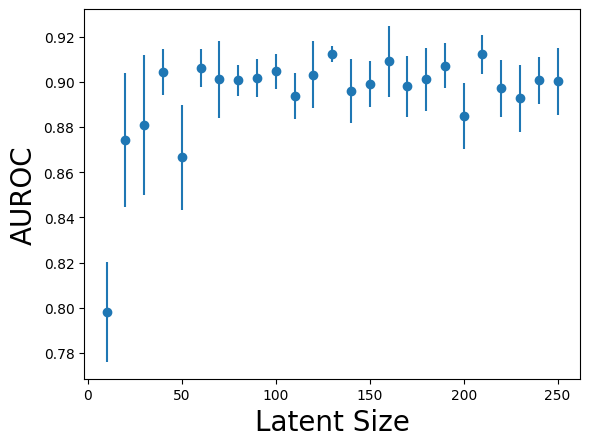

In [98]:
plt.errorbar(oth, oth_aurocs, yerr=err, fmt='o')

plt.ylabel('AUROC', fontsize=20)
plt.xlabel('Latent Size', fontsize=20)

saveplot('Figures/latentauroc')